In [159]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy import sparse as sps
from sklearn.metrics import mean_squared_error
# from ast import literal_eval
# from scipy.sparse.linalg import svds
import statistics
from math import sqrt
from scipy import sparse
import logging

In [160]:
EPS = 00000000000000.4

## Učitavanje skupa podataka ratings.csv

In [161]:
data_path = 'datasets/'
ratings_filename = 'ratings.csv'

ratings_df = pd.read_csv(os.path.join(data_path, ratings_filename), usecols=['userId', 'movieId', 'rating'], dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## Kreiranje matrice [broj_korisnika x broj_filmova] i njen grafički prikaz
Potrebno je napraviti matricu svih korisnika i svih filmova, odnosno matricu dimenzija broj_korisnika x broj_filmova. Ova matrica se može napraviti uz pomoć funkcije pivot koja se poziva nad DataFrame-om.

In [162]:
ratings_pivot_df = ratings_df.pivot(index='userId',columns='movieId',values='rating')
ratings_pivot_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nedostajući podaci koji se javljaju prilikom ovog procesa trebaju biti zamenjeni nulama, kako bi nadalje nad njima mogla da se vrše potrebna izračunavanja.

In [163]:
pivot_ratings = ratings_pivot_df.fillna(0)
pivot_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Provera dimenzije matrice, odnosno broja jedinstvenih korisnika i jedinstvenih filmova. Prema podacima iz sveske Data_analysis u kojoj su ovi podaci ispitani: "Postoji 610 jedinstvenih korisnika i 9724 jedinstvenih filmova u ovom skupu podataka.".

In [164]:
print('Dimenzije matrice ocena: ', pivot_ratings.shape) # poklapa se sa brojem jedinstvenih korisnika odnosno filmova

Dimenzije matrice ocena:  (610, 9724)


Matrica ratings_pivot je retka matrica, pa se može iskoristiti funkcija csr_matrix iz scipy.sparse paketa, koja čuva informacije o matrici na specifican način koji zauzima manje memorijskog prostora.

In [165]:
ratings_csr_matrix = sps.csr_matrix(pivot_ratings)
print('Retka matrica:\n', ratings_csr_matrix.todense()) # toarray vraća ndarray; todense vraća matrix

Retka matrica:
 [[4.  0.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  0.  ... 0.  0.  0. ]]


In [166]:
print('Dimenzije retke matrice: ', ratings_csr_matrix.shape)

Dimenzije retke matrice:  (610, 9724)


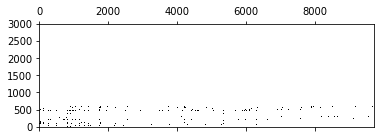

In [167]:
# Grafički prikaz elemenata retke matrice

plt.spy(ratings_csr_matrix.toarray())
# plt.axis('equal')
plt.xlim(0, 9724)
plt.ylim(0, 3000)
plt.show()

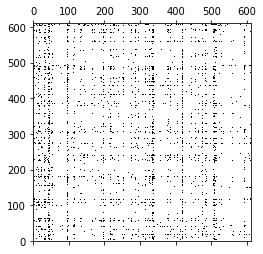

In [168]:
# Grafički prikaz elemenata retke matrice posmatrano na manjem intervalu

plt.spy(ratings_csr_matrix.toarray())
plt.xlim(0, 610)
plt.ylim(0, 610)
plt.show()

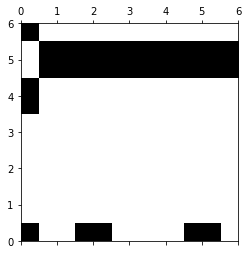

In [169]:
# Grafički prikaz elemenata retke matrice posmatrano na još manjem intervalu

plt.spy(ratings_csr_matrix.toarray())
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.show()

## Podela skupa podataka na skup za trening i skup za testiranje

### 1. način podele - funkcija za prebacivanje ocena iz trening skupa u test skup

Naredna funkcija deli podatke na skup za treniranje i skup za testiranje u datoj razmeri. Matrice u oba skupa će biti istih dimenzija, ali sa drugačije raspoređenim ocenama.

In [170]:
# Podela datog skupa podataka na skup za trening i skup za test se u narednoj funkciji
# vrši tako sto se iz datog skupa "uzima" procenat ocena koje se upisuju u test skup,
# a uklanjaju iz trening skupa

# parametar ratings_csr_matrix je skup podataka koji treba podeliti na trening i test skup
# percentage je broj koji predstavlja procenat ocena koje ulaze u test skup

def split_train_test(ratings_csr_matrix, percentage):
    
    test_ratings_number = percentage / 100
    print("Odnos ocena u skupu za testiranje: ", percentage, "%")
    print("Odnos ocena u skupu za treniranje: ", 100-percentage, "%")

    total_ratings = ratings_csr_matrix.toarray()

    dimensions_of_total_ratings = total_ratings.shape
    print("Ukupan broj korisnika: ", dimensions_of_total_ratings[0])
    print("Ukupan broj filmova: ", dimensions_of_total_ratings[1])

    test = np.zeros(dimensions_of_total_ratings)
    train = total_ratings.copy()

    nonzero_ratings_per_row = (total_ratings != 0).sum(1)
    print("Ukupan broj ne-nula ocena u svim redovima: \n", nonzero_ratings_per_row)
    
    for user in range(dimensions_of_total_ratings[0]):
        
        # indeksi ne-nula elemenata
        nonzero_test_ratings_per_user = int(np.ceil(test_ratings_number*nonzero_ratings_per_row[user]))
        # print("Ukupan broj ne-nula ocena u test skupu po korisniku: ", nonzero_test_ratings_per_user)
        
        test_ratings = np.random.choice(total_ratings[user, :].nonzero()[0], size = nonzero_test_ratings_per_user, replace = False)

        # izbacuju se iz trening skupa (upisuju se nule na odabranim pozicijama)
        train[user, test_ratings] = 0

        # ubacuju se u test skup (upisuju se ocene iz polaznog skupa, koje su uklonjene iz trening skupa)
        test[user, test_ratings] = total_ratings[user, test_ratings]
        
    if (not(np.all((train * test) == 0))):
        print("Greska!")
    else:    
        return sps.csr_matrix(train),sps.csr_matrix(test)

### 2. način podele - funkcija za stratifikovanu podelu po id-evima korisnika

Naredna funkcija za podelu koristi bibliotečku funkciju train_test_split (biblioteke sklearn, modula model_selection).

In [171]:
def train_test_stratified_split(ratings):
    y=ratings['userId']
    x=ratings.drop(columns=['userId'])
    
    from sklearn import model_selection
    x_train, x_test, y_train, y_test = model_selection.train_test_split(x,y,test_size=0.33,random_state=7,stratify=y)
    
    return x_train, x_test, y_train, y_test

## Funkcija za sortiranje liste opadajuće

In [172]:
# Funkcija koja sortira datu listu opadajuće

def sort_descending(li):
    # reverse (opcioni parametar)
    # reverse = True - sortirana lista se preokreće (postaje sortirana opadajuće)
    # reverse = None - lista ostaje sortirana rastuće
    li.sort(key = lambda x: x[0], reverse=True)
    return li

## Funkcija koja implementira User-based pristup

In [173]:
# Funkcija računa ocenu korisnika u za film i na osnovu matrice sličnosti korisnika

def user_based_ratings_prediction(u, i, users_similarity, ratings, k = 5):
    
    neighbors = []
    similarities = list(zip(users_similarity[u][:], range(users_similarity.shape[0])))

    similarities_sorted = sort_descending(similarities)
    
    # najslicnijih k
    for i in range(1, k + 1):
        neighbors.append(similarities_sorted[i][1])
    # print ("neighbors: ", neighbors)

    rated_by_u = ratings[u].nonzero()[1]
    # print("Ocenio korisnik u: ", rated_by_u)
    
    user_u_mean = 0
    arr = ratings[u, :].toarray()[0]
    user_u_mean = np.sum(arr)
        
    if len(rated_by_u) != 0:
        user_u_mean = user_u_mean / len(rated_by_u)
        
    numerator, denominator = 0.0, 0.0

    for v in neighbors:
        rated_by_v = ratings[v].nonzero()[1]
        user_v_mean = 0
        # user_v_mean = sum(ratings[v, :].toarray()[0])
            
        if len(rated_by_v) != 0:
            for i in rated_by_v:
                user_v_mean += ratings[v, i]
            
            user_v_mean = user_v_mean / len(rated_by_v)
      

        r_vi = ratings[v,i]
        numerator += users_similarity[u][v]*(r_vi - user_v_mean)
        denominator += users_similarity[u][v]
        
    return user_u_mean + numerator/denominator

## Funkcija koja implementira Item-based pristup

In [174]:
# Funkcija računa ocenu korisnika u za film i na osnovu matrice sličnosti filmova

def item_based_ratings_prediction(u, i, movies_similarity, ratings, k = 5):        

    neighbors = []
    similarities = list(zip(movies_similarity[i][:],range(movies_similarity.shape[0])))
    similarities_sorted = sort_descending(similarities)
    
    for i in range(1,k+1):
        neighbors.append(similarities_sorted[i][1])
        
    rated_i = ratings[:, i].nonzero()[0]
        
    item_i_mean = 0
    item_i_mean = np.sum(ratings[:, i].toarray()[0])
    
    if len(rated_i) != 0:
        item_i_mean = item_i_mean / len(rated_i)
        
    numerator, denominator = 0.0, 0.0
        
    for j in neighbors:
        rated_j = ratings[:, j].nonzero()[0]
        item_j_mean = 0
        
        if len(rated_j) != 0:
            arr2 = ratings[:, j].toarray()[0]
            item_j_mean = np.sum(arr2)
            item_j_mean = item_j_mean / len(rated_j)
        
        r_uj = ratings[u,j]
        numerator += movies_similarity[i][j]*(r_uj - item_j_mean)
        denominator += movies_similarity[i][j]
        
    return item_i_mean + numerator/denominator

## Funkcija za predikciju na osnovu tipa <i>"user"</i> ili <i>"item"</i>

In [175]:
# Funkcija za predviđanje ocena svih korisnika za sve filmove
# koja primenjuje user-based ili item-based pristup,
# zavisno od prosleđenog parametra

def get_prediction(ratings, similarity_matrix, cf_type, k = 5):
    predictions = np.zeros(ratings.shape)
    
    if cf_type == 'user':
        
        for u in range(ratings.shape[0]):
            # print('Predvidjanje ocene za korisnika u = ', u)
            for i in range(ratings.shape[1]):
                # print('Predvidjanje ocene za korisnika u = {} i film i = {}.'.format(u, i))
                predictions[u,i] = user_based_ratings_prediction(u, i, similarity_matrix , ratings, k)
                
    elif cf_type == 'item':
        
        for u in range(ratings.shape[0]):
            # print('Predvidjanje ocene za korisnika u = ', u)
            for i in range(ratings.shape[1]):
                # print('Predvidjanje ocene za korisnika u = {} i film i = {}.'.format(u, i))
                predictions[u,i] = item_based_ratings_prediction(u, i, similarity_matrix, ratings, k)
                
    else:
        print("Greska! Tip mora biti user ili item.")
        return

    return predictions

## Funkcija za odabir najbolje k vrednosti

In [176]:
# Funkcija vrši predviđanje ocena za sve korisnike i sve filmove
# za različite vrednosti parametra k (različit broj suseda)

def selection(train_and_validation, k_values, cf_type):
    
    print('k_values = ', k_values)
    train, validation = split_train_test(train_and_validation, 20) # TODO staviti percentage umesto 20
    errors = np.array([])
    predictions_arr = np.array([])
    
    if cf_type == 'user':
        
        similarity = cosine_similarity(train) + EPS
        
        for k in k_values:
            print('k = ', k)
            predictions = get_prediction(train, similarity, 'user', k)
            error = np.sqrt(mean_squared_error(validation.toarray()[validation.nonzero()],predictions[validation.nonzero()]))
        
            errors = np.append(errors, error)
            predictions_arr = np.append(predictions_arr, predictions)
    else:
        
        similarity = cosine_similarity(train.T) + EPS
        
        for k in k_values:
            print('k = ', k)
            predictions = get_prediction(train, similarity, 'item', k)
            error = np.sqrt(mean_squared_error(validation.toarray()[validation.nonzero()],predictions[validation.nonzero()]))
            
            errors = np.append(errors, error)
            predictions_arr = np.append(predictions_arr, predictions)
        
    k_optimal = k_values[np.argmin(errors)]
    
    if cf_type == 'user':
        similarity = cosine_similarity(train_and_validation) + EPS
        predictions = get_prediction(train_and_validation, similarity, 'user', k_optimal)
        return errors, predictions
    else:
        similarity = cosine_similarity(train_and_validation.T) + EPS
        predictions = get_prediction(train_and_validation, similarity, 'item', k_optimal)
        return errors, predictions

## Funkcija za filtriranje podataka - zadržavaju se korisnici koji su dali više od m ocena

In [177]:
# Funkcija koja filtrira matricu ocena tako da ostaju redovi koji imaju više od m ne-nula elemenata

def filter_users(train_and_validation, m):
    xy = train_and_validation.toarray()
    xy_filtered_matrix = []
    for y in xy:
        sum = 0
        nz = np.count_nonzero(y)
        if (nz > m):
            xy_filtered_matrix.append(y)

    arr_shape = np.vstack(xy_filtered_matrix).shape
    filtered_arr = np.vstack(xy_filtered_matrix)
    
    return sps.csr_matrix(filtered_arr)

## Izvršavanje implementiranih funkcija

### 1 Priprema podataka za odabir najbolje k vrednosti koristeći 1. način podele skupa (ne koristi stratifikaciju)

### 1.1 Filtriranje matrice

In [178]:
filtered_arr_sparse = filter_users(ratings_csr_matrix, m = 700)
print('Dimenzije filtrirane matrice su: ', filtered_arr_sparse.shape)

Dimenzije filtrirane matrice su:  (26, 9724)


### 1.2 Grafički prikaz filtrirane (gušće) matrice

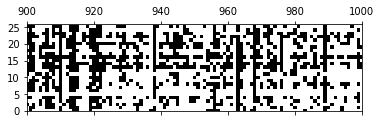

In [179]:
plt.spy(filtered_arr_sparse.toarray())
# plt.axis('equal')
plt.xlim(900, 1000) # uzet je interval od 900 do 1000 za id filma jer je prikaz previše sitan ako se obuhvate svi filmovi
plt.ylim(0, filtered_arr_sparse.shape[0]) # broj korisnika
plt.show()

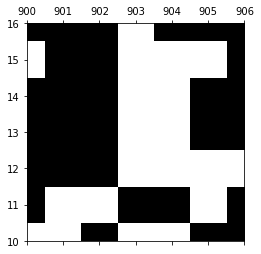

In [180]:
plt.spy(filtered_arr_sparse.toarray())
# plt.axis('equal')
plt.xlim(900, 906)
plt.ylim(10, 16)
plt.show()

### 1.3 Redukcija matrice

In [181]:
ratings_csr_reduced = filtered_arr_sparse[:filtered_arr_sparse.shape[0], 900:1000]
print('Dimenzije redukovane matrice: ', ratings_csr_reduced.shape)

Dimenzije redukovane matrice:  (26, 100)


### 1.4 Podela skupa podataka

In [182]:
train_and_validation, test = split_train_test(ratings_csr_reduced, 30)

Odnos ocena u skupu za testiranje:  30 %
Odnos ocena u skupu za treniranje:  70 %
Ukupan broj korisnika:  26
Ukupan broj filmova:  100
Ukupan broj ne-nula ocena u svim redovima: 
 [20 30 32 32 50  7 18 36 50 29 29 23 29 66 61 30 76 35 23 45 60 34 60 49
 26 32]


Primetimo da je broj ne-nula ocena u mnogim redovima manji od postavljene granice m, ali to je zbog toga što smo redukovali skup (smanjili broj filmova - zbog vremena izvršavanja).

### 2 Priprema podataka za odabir najbolje k vrednosti koristeći 2. način podele skupa (koristi stratifikaciju)

### 2.1 Podela skupa podataka

In [183]:
# Ulaz train_test_stratified_split mora biti DataFrame
# Provera tipa
type(ratings_csr_reduced) 

scipy.sparse.csr.csr_matrix

In [184]:
# Konvertovanje u DataFrame
mat = pd.DataFrame.sparse.from_spmatrix(ratings_csr_reduced)
# Provera tipa
type(mat)

pandas.core.frame.DataFrame

In [185]:
# Filtrirana i redukovana matrica (iako je konvertovana u DataFrame)
# nije pogodna za stratifikovanu podelu jer nema kolone 'userId', 'movieId', 'rating'
# x_train_validation, x_test, y_train_validation, y_test = train_test_stratified_split(mat)

# Stoga, funkcija train_test_stratified_split će biti demonstrirana za ratings_df
x_train_validation, x_test, y_train_validation, y_test = train_test_stratified_split(ratings_df)

In [186]:
# Tipovi dobijenih skupova
type(x_test), type(y_test)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [187]:
# Dužine y
len(y_test.unique()), len(y_test), len(y_train_validation.unique())

(610, 33276, 610)

In [188]:
# Dimenzije skupa za test i skupova za trening i validaciju
y_test.shape, y_train_validation.shape, x_train_validation.shape

((33276,), (67560,), (67560, 2))

### 2.2 Vizualni prikaz stratifikovanosti

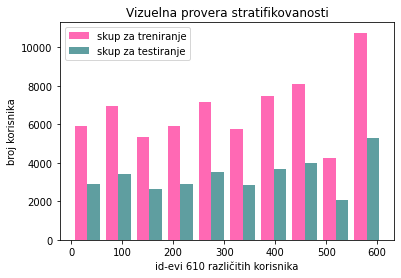

In [189]:
plt.title("Vizuelna provera stratifikovanosti")
#plt.xticks(np.linspace(0, 610, 10))
plt.xlabel('id-evi 610 različitih korisnika')
plt.ylabel('broj korisnika')
plt.hist([y_train_validation, y_test], color=['hotpink', 'cadetblue'], label=['skup za treniranje', 'skup za testiranje'])
plt.legend(loc='best')
plt.show()

### 2.3 Spajanje ciljne promenljive sa ostalim kolona

In [190]:
# Spajanje x i y za test skup
test_ratings = pd.concat([x_test, y_test], axis=1)
# Dimenzije
test_ratings.shape

(33276, 3)

In [191]:
# Prikaz test_ratings
test_ratings

,movieId,rating,userId
83904,71535,4.0,534
28790,2943,4.0,199
24288,3334,4.5,168
8421,2935,4.0,57
59822,4195,3.5,387
...,...,...,...
76720,4993,3.5,480
49214,3911,3.5,318
46813,433,1.5,307
86347,7460,4.0,560


In [192]:
# Spajanje x i y za train_validation skup
train_validation_ratings = pd.concat([x_train_validation, y_train_validation], axis=1)
# Dimenzije
train_validation_ratings.shape

(67560, 3)

In [193]:
# Prikaz train_validation_ratings
train_validation_ratings

,movieId,rating,userId
50071,34405,3.5,322
13707,25887,5.0,89
69376,4660,4.0,448
44298,2792,4.0,294
74819,7618,3.5,474
...,...,...,...
8766,1201,4.5,61
9645,2193,3.5,64
1971,4728,3.0,18
77873,88356,3.0,483


### 2.4 Kreiranje pivot tabela  za skupove train_validation i test

In [194]:
test_ratings_pivot_df = test_ratings.pivot(index='userId',columns='movieId',values='rating').fillna(0)
train_validation_ratings_pivot_df = train_validation_ratings.pivot(index='userId',columns='movieId',values='rating').fillna(0)

# Dimenzije
train_validation_ratings_pivot_df.shape, test_ratings_pivot_df.shape

((610, 8428), (610, 6351))

In [195]:
# Prikaz train_validation_ratings_pivot_df
train_validation_ratings_pivot_df

movieId,1,2,3,4,5,6,7,8,9,10,...,190215,190219,190221,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [196]:
# Prikaz test_ratings_pivot_df
test_ratings_pivot_df

movieId,1,2,3,4,5,6,7,9,10,11,...,187593,187595,187717,188301,188675,189333,191005,193565,193567,193571
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,2.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.5 Kreiranje sparse matrica za skupove train_validation i test

In [197]:
train_validation_ratings_csr_matrix = sps.csr_matrix(train_validation_ratings_pivot_df)
test_ratings_csr_matrix = sps.csr_matrix(test_ratings_pivot_df)

print('Train csr matrica\n', train_validation_ratings_csr_matrix.todense())
print('Test csr matrica\n', test_ratings_csr_matrix.todense())

Train csr matrica
 [[4.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  2.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]
Test csr matrica
 [[0. 0. 4. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]]


### 2.6 Filtriranje

In [198]:
filtered_arr_sparse_stratified = filter_users(train_validation_ratings_csr_matrix, 200)

In [199]:
# Dimenzije
filtered_arr_sparse_stratified.shape

(84, 8428)

### 2.7 Redukcija

In [200]:
filtered_reduced_stratified_ratings = filtered_arr_sparse_stratified[:filtered_arr_sparse_stratified.shape[0], 900:1000]
print('Dimenzije redukovane matrice: ', filtered_reduced_stratified_ratings.shape)

Dimenzije redukovane matrice:  (84, 100)


### Određivanje najbolje k vrednosti i računanje RMSE
U nastavku će biti izvršene funkcije koje biraju najbolju vrednost za parametar k u slučaju zasnovanom na korisnicima i slučaju zasnovanom na stavkama. Na kraju je prikazan grafik koji ilustruje promenu vrednosti korena srednje kvadratne greške za različitu vrednost parametra k.

In [201]:
k_values = [1, 2, 3, 4, 8, 10, 15, 20, 25]

### Pristup koji ne koristi stratifikovanu podelu (iz sekcije 1)

In [202]:
# USER-BASED
errors_user, predictions_user = selection(train_and_validation, k_values, 'user')

k_values =  [1, 2, 3, 4, 8, 10, 15, 20, 25]
Odnos ocena u skupu za testiranje:  20 %
Odnos ocena u skupu za treniranje:  80 %
Ukupan broj korisnika:  26
Ukupan broj filmova:  100
Ukupan broj ne-nula ocena u svim redovima: 
 [14 21 22 22 35  4 12 25 35 20 20 16 20 46 42 21 53 24 16 31 42 23 42 34
 18 22]
k =  1
k =  2
k =  3
k =  4
k =  8
k =  10
k =  15
k =  20
k =  25


In [203]:
# ITEM-BASED
errors_item, predictions_item = selection(train_and_validation, k_values, 'item')

k_values =  [1, 2, 3, 4, 8, 10, 15, 20, 25]
Odnos ocena u skupu za testiranje:  20 %
Odnos ocena u skupu za treniranje:  80 %
Ukupan broj korisnika:  26
Ukupan broj filmova:  100
Ukupan broj ne-nula ocena u svim redovima: 
 [14 21 22 22 35  4 12 25 35 20 20 16 20 46 42 21 53 24 16 31 42 23 42 34
 18 22]
k =  1
k =  2
k =  3
k =  4
k =  8
k =  10
k =  15
k =  20
k =  25


### Pristup koji koristi stratifikovanu podelu (iz sekcije 2)

In [204]:
# USER-BASED
errors_user_stratified_user, predictions_user_stratified_user = selection(filtered_reduced_stratified_ratings, k_values, 'user')

k_values =  [1, 2, 3, 4, 8, 10, 15, 20, 25]
Odnos ocena u skupu za testiranje:  20 %
Odnos ocena u skupu za treniranje:  80 %
Ukupan broj korisnika:  84
Ukupan broj filmova:  100
Ukupan broj ne-nula ocena u svim redovima: 
 [ 0  4 23  3  7  9 12  8  7 15  3 12 11 15  7 21  7  8  1  3  9 10 18 11
 16 24 15  6 20 19  5 14  8  6  6 16 12 29  5  6  5  9 18 11 10  2 13  7
 13  6 29 13 33  3  1  6 15  3 12 21 39 13 17  9 10  2 15  7  4  1 22  3
 11  1  7 24  6 15 29 18 33 23 12  8]
k =  1
k =  2
k =  3
k =  4
k =  8
k =  10
k =  15
k =  20
k =  25


In [205]:
# ITEM-BASED
errors_user_stratified_item, predictions_user_stratified_item = selection(filtered_reduced_stratified_ratings, k_values, 'item')

k_values =  [1, 2, 3, 4, 8, 10, 15, 20, 25]
Odnos ocena u skupu za testiranje:  20 %
Odnos ocena u skupu za treniranje:  80 %
Ukupan broj korisnika:  84
Ukupan broj filmova:  100
Ukupan broj ne-nula ocena u svim redovima: 
 [ 0  4 23  3  7  9 12  8  7 15  3 12 11 15  7 21  7  8  1  3  9 10 18 11
 16 24 15  6 20 19  5 14  8  6  6 16 12 29  5  6  5  9 18 11 10  2 13  7
 13  6 29 13 33  3  1  6 15  3 12 21 39 13 17  9 10  2 15  7  4  1 22  3
 11  1  7 24  6 15 29 18 33 23 12  8]
k =  1
k =  2
k =  3
k =  4
k =  8
k =  10
k =  15
k =  20
k =  25


### Ispis informacija za parametar k u log fajl

In [206]:
# Kreiranje i konfigurisanje logging-a
logging.basicConfig(filename="std.log", format='%(asctime)s %(message)s', filemode='w') 

logger=logging.getLogger() 
logger.setLevel(logging.DEBUG) 

# Pisanje u log file
logger.info('Pristup koji ne koristi stratifikovanu podelu')
logger.info('User-based')
logger.info('Errors (user-based):')
logger.info(errors_user) 
logger.info('User-based best k:') 
logger.info(k_values[np.argmin(errors_user)])
logger.info('------------------------------------')
logger.info('Item-based')
logger.info('Errors (user-based):')
logger.info(errors_item) 
logger.info('User-based best k:') 
logger.info(k_values[np.argmin(errors_item)])
logger.info('------------------------------------')
logger.info('Pristup koji koristi stratifikovanu podelu')
logger.info('User-based')
logger.info('Errors (user-based):')
logger.info(errors_user_stratified_user) 
logger.info('User-based best k:') 
logger.info(k_values[np.argmin(errors_user_stratified_user)])
logger.info('------------------------------------')
logger.info('Item-based')
logger.info('Errors (user-based):')
logger.info(errors_user_stratified_item) 
logger.info('User-based best k:') 
logger.info(k_values[np.argmin(errors_user_stratified_item)])

### Grafički prikaz RMSE

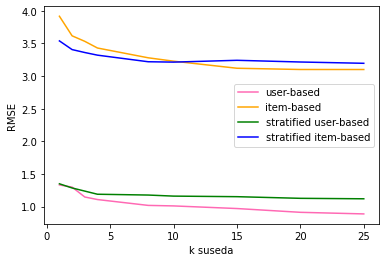

In [209]:
plt.plot(k_values, errors_user, color = 'hotpink', label = 'user-based')
plt.plot(k_values, errors_item, color = 'orange', label = 'item-based')
plt.plot(k_values, errors_user_stratified_user, color = 'green', label = 'stratified user-based')
plt.plot(k_values, errors_user_stratified_item, color = 'blue', label = 'stratified item-based')
plt.legend(loc='best')
plt.xlabel('k suseda')
plt.ylabel('RMSE')
plt.show()